<a href="https://colab.research.google.com/github/ujjawalsingh10/DCGAN-for-Image-Generation/blob/main/Animal_Images_Generation_using_DCGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer
from tensorflow.keras.layers import Reshape, Conv2DTranspose, Add, Conv2D, MaxPool2D, Dense, Flatten, InputLayer, BatchNormalization, Input, LeakyReLU
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
#!unzip '/content/drive/MyDrive/CT/Bipolar_Factory/animals.zip' -d '/content/drive/MyDrive/CT/Bipolar_Factory/Animal_Images_Dataset'

## Data Preparation

In [3]:
BATCH_SIZE = 128
IM_SHAPE = (64,64,3)
LEARNING_RATE = 2e-4
LATENT_DIM = 100

In [4]:
## Load the iamges
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    '/content/drive/MyDrive/CT/Bipolar_Factory/Animal_Images_Dataset', label_mode = None, image_size = (IM_SHAPE[0], IM_SHAPE[1]), batch_size = BATCH_SIZE,
)

Found 14630 files belonging to 1 classes.


In [5]:
dataset

<_BatchDataset element_spec=TensorSpec(shape=(None, 64, 64, 3), dtype=tf.float32, name=None)>

In [6]:
## Preprocessing images
def preprocess(image):
  return tf.cast(image, tf.float32) / 127.5 - 1.0

In [7]:
### Preprocessing the dataset and using batches and prefetching
train_dataset = (
    dataset
    .map(preprocess)
    .unbatch()
    .shuffle(buffer_size = 1024, reshuffle_each_iteration = True)
    .batch(BATCH_SIZE, drop_remainder = True)
    .prefetch(tf.data.AUTOTUNE)
)

In [8]:
for d in train_dataset.take(1):
  print(d.shape)

(128, 64, 64, 3)


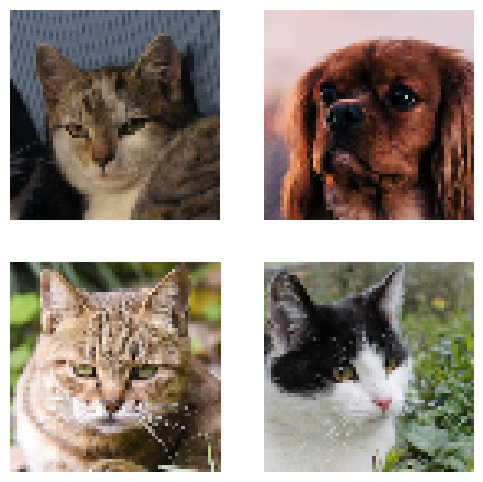

In [9]:
plt.figure(figsize=(6, 6))
k = 0
n = 4
for i in range(n):
  ax = plt.subplot(2,2, k + 1 )
  plt.imshow((d[i] + 1) / 2) ## Imshow takes values bw 0 and 1
  plt.axis('off')
  k+=1

## Modelling

In [10]:
### Create the generator model
generator = tf.keras.Sequential([
    Input(shape = (LATENT_DIM, )),
    Dense(4*4*LATENT_DIM),
    Reshape((4,4, LATENT_DIM)),

    Conv2DTranspose(512, kernel_size = 4, strides = 2, padding = 'same'),
    BatchNormalization(),
    LeakyReLU(0.2),

    Conv2DTranspose(256, kernel_size = 4, strides = 2, padding = 'same'),
    BatchNormalization(),
    LeakyReLU(0.2),

    Conv2DTranspose(128, kernel_size = 4, strides = 2, padding = 'same'),
    BatchNormalization(),
    LeakyReLU(0.2),

    Conv2DTranspose(3, kernel_size = 4, strides = 2, activation = 'tanh', padding = 'same'),


], name = 'generator')

In [11]:
generator.summary()

Model: "generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 1600)              161600    
                                                                 
 reshape (Reshape)           (None, 4, 4, 100)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 8, 8, 512)        819712    
 nspose)                                                         
                                                                 
 batch_normalization (BatchN  (None, 8, 8, 512)        2048      
 ormalization)                                                   
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 8, 8, 512)         0         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 16, 16, 256)      20

In [12]:
### Create the discriminator model
discriminator = tf.keras.Sequential([
    Input(shape = (IM_SHAPE[0], IM_SHAPE[1], 3)),

    Conv2D(64, kernel_size = 4, strides = 2, padding = 'same'),
    LeakyReLU(0.2),

    Conv2D(128, kernel_size = 4, strides = 2, padding = 'same'),
    BatchNormalization(),
    LeakyReLU(0.2),

    Conv2D(256, kernel_size = 4, strides = 2, padding = 'same'),
    BatchNormalization(),
    LeakyReLU(0.2),

    Conv2D(1, kernel_size = 4, strides = 2, padding = 'same'),

    Flatten(),
    Dense(1, activation = 'sigmoid')

], name = 'discriminator')

In [13]:
discriminator.summary()

Model: "discriminator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 64)        3136      
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 32, 32, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 128)       131200    
                                                                 
 batch_normalization_3 (Batc  (None, 16, 16, 128)      512       
 hNormalization)                                                 
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 16, 16, 128)       0         
                                                                 
 conv2d_2 (Conv2D)           (None, 8, 8, 256)         524544    
                                                     

In [14]:
class GAN(tf.keras.Model):
  def __init__(self,discriminator, generator):
    super(GAN,self).__init__()
    self.discriminator=discriminator
    self.generator=generator

  def compile(self, d_optimizer, g_optimizer, loss_fn):
    super(GAN, self).compile()
    self.d_optimizer = d_optimizer
    self.g_optimizer = g_optimizer
    self.loss_fn = loss_fn
    self.d_loss_metric = tf.keras.metrics.Mean(name='d_loss')
    self.g_loss_metric = tf.keras.metrics.Mean(name='g_loss')

  @property
  def metrics(self):
    return [self.d_loss_metric, self.g_loss_metric]

  def train_step(self,real_images):
    batch_size = tf.shape(real_images)[0]

    ########## Discriminator #############
    random_noise = tf.random.normal(shape = (batch_size, LATENT_DIM))
    fake_images = self.generator(random_noise)

     ## We compare real images with values around 1 and fakes with around 0
    real_labels = tf.ones((batch_size, 1)) + 0.25*tf.random.uniform((batch_size, 1), minval = -1, maxval = 1)
    fake_labels = tf.zeros((batch_size, 1)) + 0.25*tf.random.uniform((batch_size, 1)) ## by default val min, max 0-1

    with tf.GradientTape() as recorder:
      real_predictions = self.discriminator(real_images)
      d_loss_real = self.loss_fn(real_labels, real_predictions)

      fake_predictions = self.discriminator(fake_images)
      d_loss_fake = self.loss_fn(fake_labels, fake_predictions)

      d_loss = d_loss_fake + d_loss_real

    partial_derivatives = recorder.gradient(d_loss,self.discriminator.trainable_weights)
    self.d_optimizer.apply_gradients(zip(partial_derivatives, self.discriminator.trainable_weights))

    ########### Generator  ##############

    random_noise=tf.random.normal(shape=(batch_size,LATENT_DIM))
    flipped_fake_labels=tf.ones((batch_size,1))

    with tf.GradientTape() as recorder:

      fake_predictions=self.discriminator(self.generator(random_noise))
      g_loss=self.loss_fn(flipped_fake_labels,fake_predictions)

    partial_derivatives = recorder.gradient(g_loss,self.generator.trainable_weights)
    self.g_optimizer.apply_gradients(zip(partial_derivatives, self.generator.trainable_weights))

    self.d_loss_metric.update_state(d_loss)
    self.g_loss_metric.update_state(g_loss)

    return {'d_loss':self.d_loss_metric.result(),
            'g_loss':self.g_loss_metric.result()}

In [15]:
EPOCHS = 150
gan = GAN(discriminator, generator)
gan.compile(
    d_optimizer = tf.keras.optimizers.Adam(learning_rate = LEARNING_RATE, beta_1 = 0.5),
    g_optimizer = tf.keras.optimizers.Adam(learning_rate = LEARNING_RATE, beta_1 = 0.5),
    loss_fn = tf.keras.losses.BinaryCrossentropy(),
)

In [16]:
## Callback to save image after every epoch
class ShowImage(tf.keras.callbacks.Callback):
    def __init__(self, latent_dim=100):
        self.latent_dim = latent_dim

    def on_epoch_end(self, epoch, logs=None):
        n=6
        k=0
        out=self.model.generator(tf.random.normal(shape=(36, self.latent_dim)))
        plt.figure(figsize=(16,16))
        for i in range(n):
          for j in range(n):
            ax=plt.subplot(n,n,k+1)
            plt.imshow((out[k]+1)/2,)
            plt.axis('off')
            k+=1
        plt.savefig("/content/drive/MyDrive/CT/Bipolar_Factory/DCGAN_Generated_Images/gen_images_epoch_{}.png".format(epoch+1))


Epoch 1/150
      6/Unknown - 16s 175ms/step - d_loss: 1.1442 - g_loss: 0.6270

114/114 [==============================] - 50s 308ms/step - d_loss: 1.0134 - g_loss: 1.5640
Epoch 2/150
114/114 [==============================] - 47s 374ms/step - d_loss: 0.9802 - g_loss: 1.6890
Epoch 3/150
114/114 [==============================] - 41s 314ms/step - d_loss: 1.0806 - g_loss: 1.4257
Epoch 4/150
114/114 [==============================] - 42s 327ms/step - d_loss: 1.1625 - g_loss: 1.2579
Epoch 5/150
114/114 [==============================] - 41s 325ms/step - d_loss: 1.1591 - g_loss: 1.3749
Epoch 6/150
114/114 [==============================] - 42s 334ms/step - d_loss: 1.1295 - g_loss: 1.3137
Epoch 7/150
114/114 [==============================] - 40s 319ms/step - d_loss: 1.2571 - g_loss: 1.0956
Epoch 8/150
114/114 [==============================] - 41s 320ms/step - d_loss: 1.2128 - g_loss: 0.9976
Epoch 9/150
114/114 [==============================] - 42s 336ms/step - d_loss: 1.2426 - g_loss: 1.1053
Epoch 10/150
114/114 [==============================] - 40s 317ms/step - d_l

<ipython-input-16-617b34437686>:9: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(16,16))


114/114 [==============================] - 41s 324ms/step - d_loss: 1.2855 - g_loss: 0.9537
Epoch 22/150
114/114 [==============================] - 44s 356ms/step - d_loss: 1.2672 - g_loss: 0.9667
Epoch 23/150
114/114 [==============================] - 40s 318ms/step - d_loss: 1.2950 - g_loss: 0.8964
Epoch 24/150
114/114 [==============================] - 40s 314ms/step - d_loss: 1.2578 - g_loss: 0.8759
Epoch 25/150
114/114 [==============================] - 42s 327ms/step - d_loss: 1.2617 - g_loss: 0.9072
Epoch 26/150
114/114 [==============================] - 40s 315ms/step - d_loss: 1.2845 - g_loss: 0.9221
Epoch 27/150
114/114 [==============================] - 40s 313ms/step - d_loss: 1.2560 - g_loss: 0.8870
Epoch 28/150
114/114 [==============================] - 42s 327ms/step - d_loss: 1.2852 - g_loss: 0.9149
Epoch 29/150
114/114 [==============================] - 40s 316ms/step - d_loss: 1.2688 - g_loss: 0.8367
Epoch 30/150
114/114 [==============================] - 41s 325ms/st

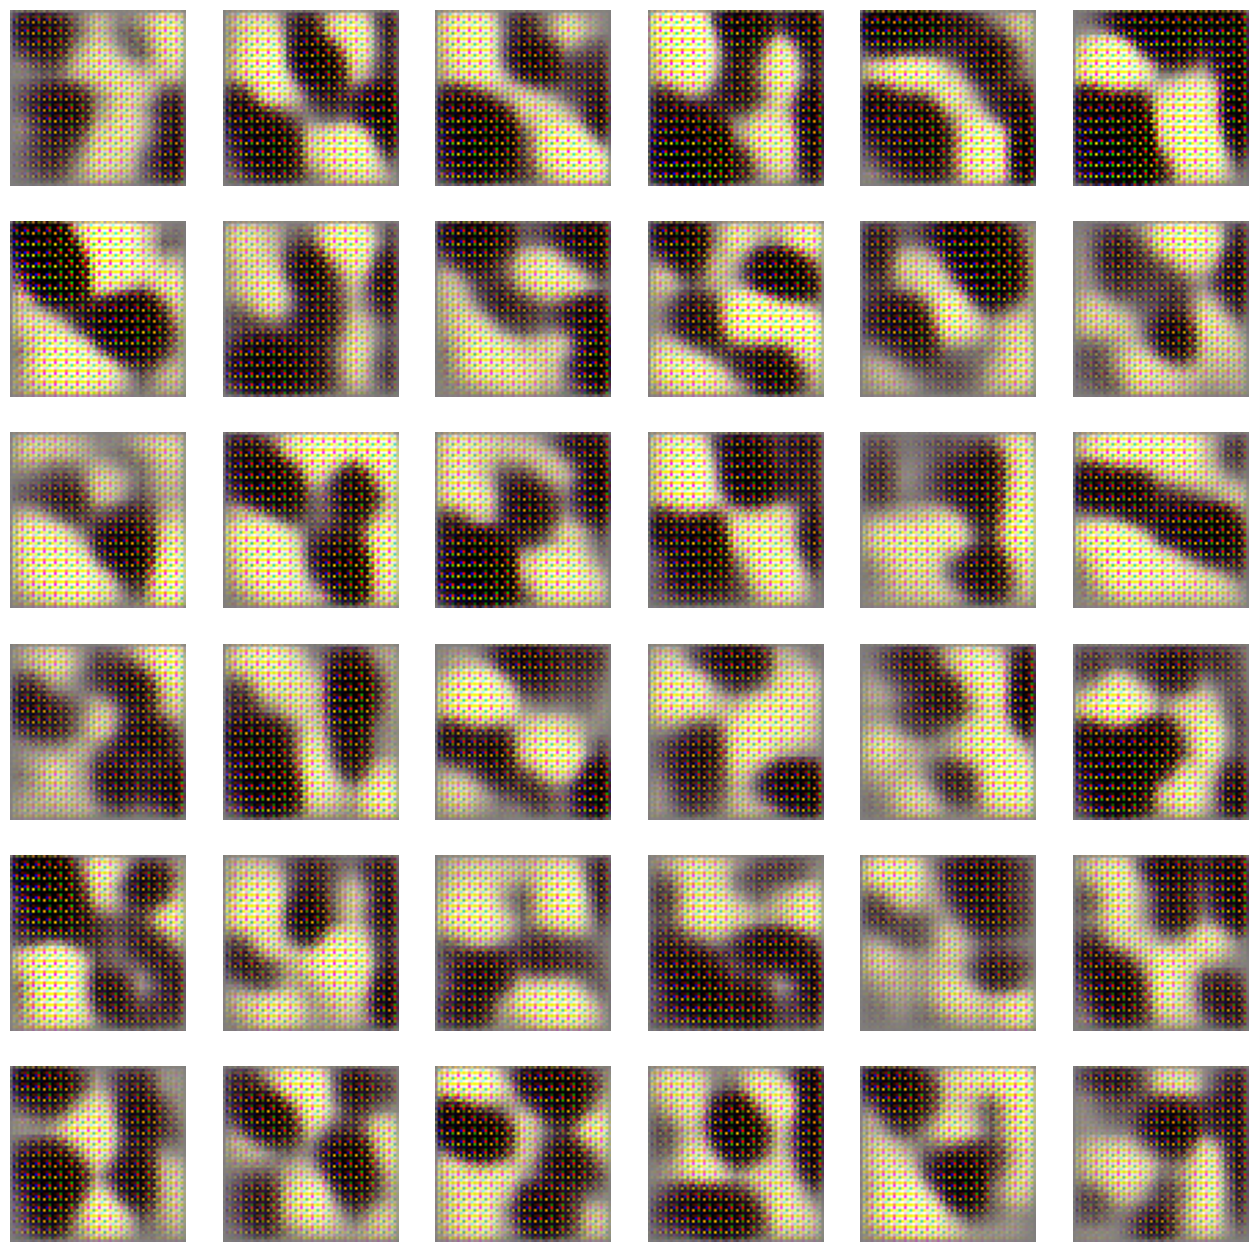

In [ ]:
history = gan.fit(train_dataset, epochs = EPOCHS, callbacks = [ShowImage(LATENT_DIM)])

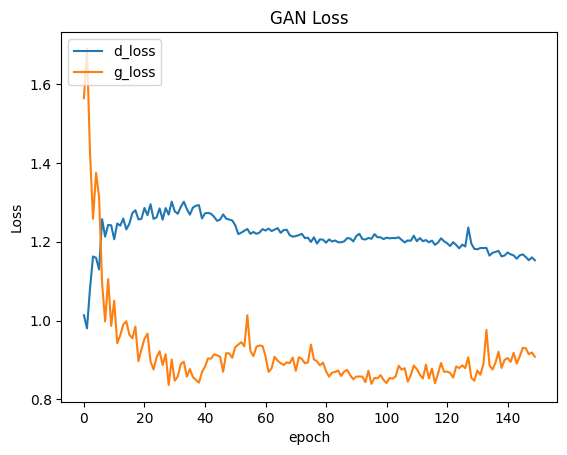

In [21]:
plt.plot(history.history['d_loss'])
plt.plot(history.history['g_loss'])
plt.title('GAN Loss')
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.legend(['d_loss', 'g_loss'], loc='upper left')
plt.show()

### Saving and Loading model

In [22]:
gan.save_weights('/content/drive/MyDrive/CT/Bipolar_Factory/Model_Weights/')

In [25]:
gan_loaded = gan.load_weights('/content/drive/MyDrive/CT/Bipolar_Factory/Model_Weights/')

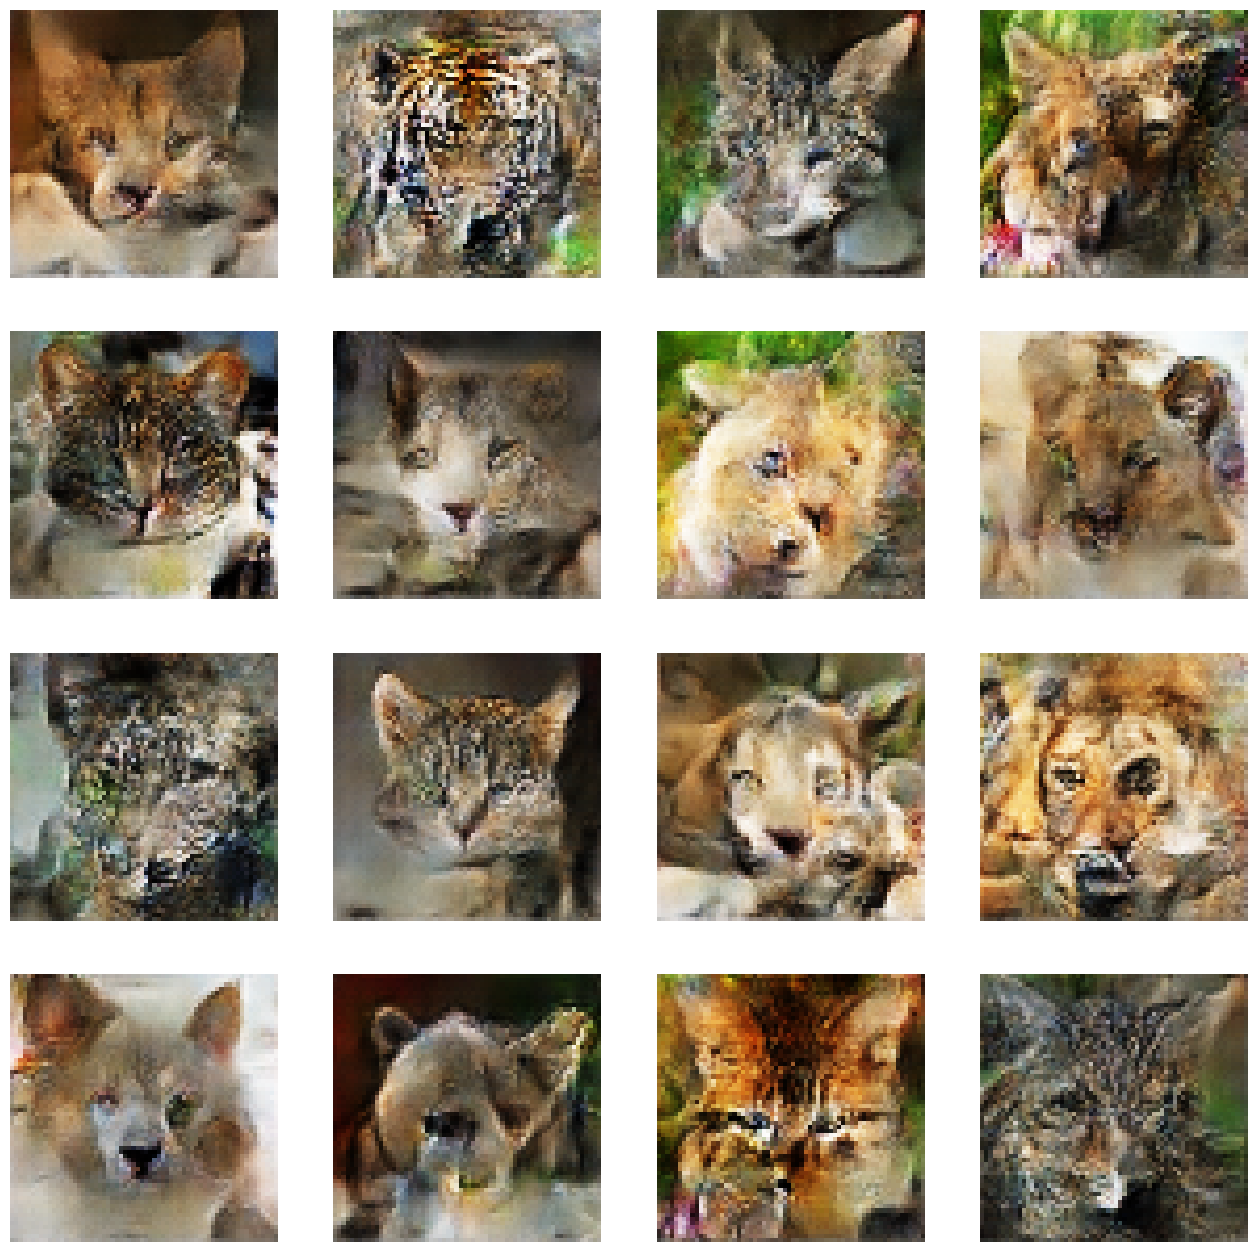

In [32]:
latent_dim = 100

n=4
k=0
out=gan.generator(tf.random.normal(shape=(36, latent_dim)))
plt.figure(figsize=(16,16))
for i in range(n):
  for j in range(n):
    ax=plt.subplot(n,n,k+1)
    plt.imshow((out[k]+1)/2,)
    plt.axis('off')
    k+=1



In [ ]:
sh